### Download Template

In [ ]:
!wget https://gist.githubusercontent.com/b1nch3f/b702d2ebfd2c751aa21b68c7425e0d4e/raw/c77225291924a8d2c33c210d74f2744210b6b716/d2l.py -O d2l.py

--2022-07-23 23:07:23--  https://gist.githubusercontent.com/b1nch3f/b702d2ebfd2c751aa21b68c7425e0d4e/raw/c77225291924a8d2c33c210d74f2744210b6b716/d2l.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59707 (58K) [text/plain]
Saving to: ‘d2l.py’

d2l.py              100%[===================>]  58.31K  --.-KB/s    in 0.004s  

2022-07-23 23:07:23 (15.6 MB/s) - ‘d2l.py’ saved [59707/59707]



### The attention pooling selectively aggregates values (sensory inputs) to produce the output.

<img src="https://classic.d2l.ai/_images/qkv.svg" />

In [ ]:
import tensorflow as tf
import d2l

tf.random.set_seed(seed=1322)

### Generating the Dataset

$y_i = 2\sin(x_i) + x_i^{0.8} + \epsilon$

In [ ]:
n_train = 50
x_train = tf.sort(tf.random.uniform(shape=(n_train,), maxval=5))

def f(x):
    return 2 * tf.sin(x) + x**0.8

y_train = f(x_train) + tf.random.normal((n_train,), 0.0, 0.5)  # Training outputs
x_test = tf.range(0, 5, 0.1)  # Testing examples
y_truth = f(x_test)  # Ground-truth outputs for the testing examples
n_test = len(x_test)  # No. of testing examples
n_test

50

In [ ]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

### Average Pooling

$f(x) = \frac{1}{n}\sum_{i=1}^n y_i$

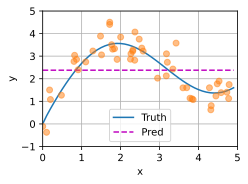

In [ ]:
y_hat = tf.repeat(tf.reduce_mean(y_train), repeats=n_test)
plot_kernel_reg(y_hat)

### Nonparametric Attention Pooling

$f(x) = \sum_{i=1}^n \frac{K(x - x_i)}{\sum_{j=1}^n K(x - x_j)} y_i$, where $K$ is a kernel

$f(x) = \sum_{i=1}^n \alpha(x, x_i) y_i$, where $x$ is the query and $(x_i, y_i)$ is the key-value pair

The attention pooling here is a weighted average of values $y_i$

The attention weight $\alpha(x, x_i)$ is assigned to the corresponding value $y_i$ based on the interaction between the query $x_i$ and the key $x_i$ modeled by $\alpha$. For any query, its attention weights over all the key-value pairs are a valid probability distribution: they are non-negative and sum up to one.

consider a Gaussian kernel defined as

$K(u) = \frac{1}{\sqrt{2\pi}} \exp(-\frac{u^2}{2})$

$\begin{split}\begin{aligned} f(x) &=\sum_{i=1}^n \alpha(x, x_i) y_i\\ &= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}(x - x_i)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}(x - x_j)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}(x - x_i)^2\right) y_i. \end{aligned}\end{split}$

a key $x_i$ that is closer to the given query $x$ will get more attention via a larger attention weight assigned to the key’s corresponding value $y_i$.



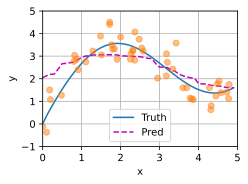

In [ ]:
# Shape of `X_repeat`: (`n_test`, `n_train`), where each row contains the
# same testing inputs (i.e., same queries)
X_repeat = tf.repeat(tf.expand_dims(x_train, axis=0), repeats=n_train, axis=0)
# Note that `x_train` contains the keys. Shape of `attention_weights`:
# (`n_test`, `n_train`), where each row contains attention weights to be
# assigned among the values (`y_train`) given each query
attention_weights = tf.nn.softmax(-(X_repeat - tf.expand_dims(x_train, axis=1))**2/2, axis=1)
# Each element of `y_hat` is weighted average of values, where weights are attention weights
y_hat = tf.matmul(attention_weights, tf.expand_dims(y_train, axis=1))
plot_kernel_reg(y_hat)

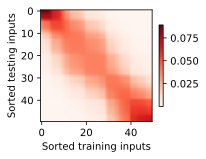

In [ ]:
d2l.show_heatmaps(tf.expand_dims(tf.expand_dims(attention_weights, axis=0), axis=0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

### Parametric Attention Pooling

In the following the distance between the query  and the key  is multiplied by a learnable parameter $w$:

$\begin{split}\begin{aligned}f(x) &= \sum_{i=1}^n \alpha(x, x_i) y_i \\&= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}((x - x_i)w)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}((x - x_j)w)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}((x - x_i)w)^2\right) y_i.\end{aligned}\end{split}$

### Batch Matrix Multiplication

In [ ]:
X = tf.ones((2, 1, 4))
Y = tf.ones((2, 4, 6))
tf.matmul(X, Y).shape

TensorShape([2, 1, 6])

In [ ]:
weights = tf.ones((2, 10)) * 0.1
values = tf.reshape(tf.range(20.0), shape = (2, 10))
tf.matmul(tf.expand_dims(weights, axis=1), tf.expand_dims(values, axis=-1)).numpy()

array([[[ 4.5]],

       [[14.5]]], dtype=float32)

### Defining the Model

In [ ]:
class NWKernelRegression(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = tf.Variable(initial_value=tf.random.uniform(shape=(1,)))

    def call(self, queries, keys, values, **kwargs):
        # For training queries are `x_train`. Keys are distance of taining data for each point. Values are `y_train`.
        # Shape of the output `queries` and `attention_weights`: (no. of queries, no. of key-value pairs)
        queries = tf.repeat(tf.expand_dims(queries, axis=1), repeats=keys.shape[1], axis=1)
        self.attention_weights = tf.nn.softmax(-((queries - keys) * self.w)**2 /2, axis =1)
        # Shape of `values`: (no. of queries, no. of key-value pairs)
        return tf.squeeze(tf.matmul(tf.expand_dims(self.attention_weights, axis=1), tf.expand_dims(values, axis=-1)))

### Training

In [ ]:
# Shape of `X_tile`: (`n_train`, `n_train`), where each column contains the
# same training inputs
X_tile = tf.repeat(tf.expand_dims(x_train, axis=0), repeats=n_train, axis=0)
# Shape of `Y_tile`: (`n_train`, `n_train`), where each column contains the
# same training outputs
Y_tile = tf.repeat(tf.expand_dims(y_train, axis=0), repeats=n_train, axis=0)
# Shape of `keys`: ('n_train', 'n_train' - 1)
keys = tf.reshape(X_tile[tf.cast(1 - tf.eye(n_train), dtype=tf.bool)], shape=(n_train, -1))
# Shape of `values`: ('n_train', 'n_train' - 1)
values = tf.reshape(Y_tile[tf.cast(1 - tf.eye(n_train), dtype=tf.bool)], shape=(n_train, -1))

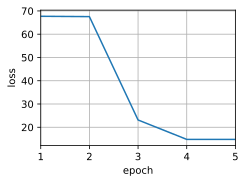

In [ ]:
net = NWKernelRegression()
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])


for epoch in range(5):
    with tf.GradientTape() as t:
        loss = loss_object(y_train, net(x_train, keys, values)) * len(y_train)
    grads = t.gradient(loss, net.trainable_variables)
    optimizer.apply_gradients(zip(grads, net.trainable_variables))
    print(f'epoch {epoch + 1}, loss {float(loss):.6f}')
    animator.add(epoch + 1, float(loss))

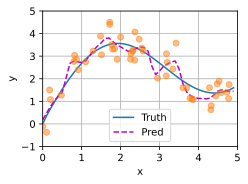

In [ ]:
# Shape of `keys`: (`n_test`, `n_train`), where each column contains the same
# training inputs (i.e., same keys)
keys = tf.repeat(tf.expand_dims(x_train, axis=0), repeats=n_test, axis=0)
# Shape of `value`: (`n_test`, `n_train`)
values = tf.repeat(tf.expand_dims(y_train, axis=0), repeats=n_test, axis=0)
y_hat = net(x_test, keys, values)
plot_kernel_reg(y_hat)

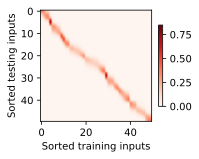

In [ ]:
d2l.show_heatmaps(tf.expand_dims(tf.expand_dims(net.attention_weights, axis=0), axis=0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')